# **Skin Cancer_Phase One**

The main objective of this project is to achieve maximum accuracy of skin disease prediction, and detect the skin cancer disease at an initial stage.

## Info About The Dataset

HAM10000 ("Human Against Machine with 10000 training images") dataset -a large collection of multi-source dermatoscopic images of pigmented lesions.

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :

1) Melanocytic nevi : nv

2) Melanoma :  mel

3) Benign keratosis-like lesions : bkl

4) Basal cell carcinoma : bcc

5) Actinic keratoses : akiec

6) Vascular lesions : vasc

7) Dermatofibroma : df

In [28]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image     
import os
import cv2 
from glob import glob
from imgaug import augmenters as aug_lib #img Augmentaion
from sklearn.model_selection import train_test_split

In [3]:
# Reading the main csv file
df = pd.read_csv("C:\\Users\\Aborizk\\Desktop\\Desktop\\Pro\\3\\HAM10000_metadata.csv")

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


General statistics to understand more about the dataset:

In [5]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


This is because age the only numerical value in the features

In [6]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

# **Data cleaning**

In [7]:
# To know if there are NULL values
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are 57 NULL records in the 'age' feature, so will take the mean of age

In [61]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [62]:
# Test again
df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

--> Null values hane been removed

In [63]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = 'C:\\Users\\Aborizk\\Desktop\\Desktop\\Pro\\3\\HAM10000_metadata.csv'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [64]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


# **Image Preprocessing**

In [ ]:
imgs = os.listdir("C:\\Users\\Aborizk\\Desktop\\Desktop\\Pro\\3\HAM10000_images_part_1\\") 
lst = []
for path in imgs:
  img = cv2.cvtColor(cv2.imread("C:\\Users\\Aborizk\\Desktop\\Desktop\\Pro\\3\HAM10000_images_part_1\\"+path),
                     cv2.COLOR_BGR2RGB)
  lst.append(img)

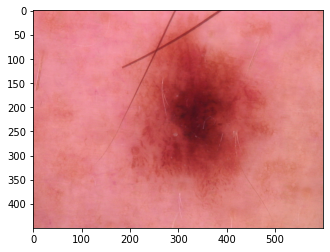

In [13]:
plt.imshow(lst[0])

In [14]:
def Display_images(images_lst):
  fig, axes = plt.subplots(1,8,figsize=(25,20),  # 1,8 =>  1 row and 8 columns
  subplot_kw={'xticks':[], 'yticks':[]},         # xticks , yticks => what will be showen in x axis and y axis
  gridspec_kw=dict(hspace=0.05, wspace=0.05)     # hspace , wspace => Spaces between images
  )
  for i, ax in enumerate(axes.flat):
    ax.imshow(images_lst[i],cmap='gray')

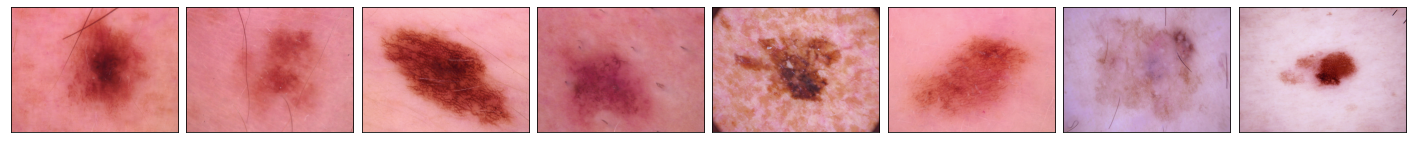

In [15]:
Display_images(lst)

# Resize Images

In [16]:
def resize(images_lst,width,height):
  res_img = []
  for img in images_lst:
    img = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    res = cv2.resize(img,  (width, height) )
    res_img.append(res)
  return res_img

In [17]:
resized_images = resize(lst,224,224)
resized_images[3].shape

(224, 224)

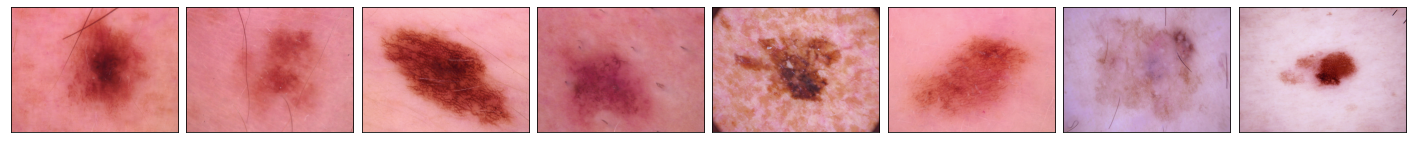

In [18]:
Display_images(lst)

# Remove Noise

## Bilateral Filter 

In [19]:
def bilateral_filter(images_lst):
  new_img = []
  for i in range(len(images_lst)):
    bilateral = cv2.bilateralFilter(images_lst[i], 5, 6, 6)  
    new_img.append(bilateral)
  return new_img

In [20]:
new_img = bilateral_filter(resized_images)

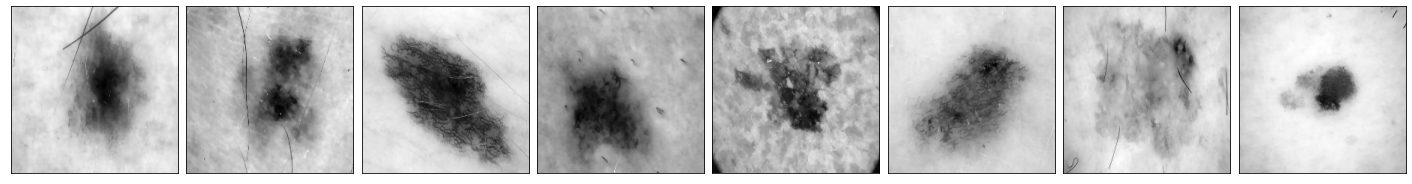

In [21]:
Display_images(new_img)

## Blur & Sharping 

In [22]:
def sharping(images_lst):
  new_imgs = []
  for i in range(len(images_lst)):
    gaussian_blur= cv2.GaussianBlur(images_lst[i], (5, 5), 0) # (5, 5) => Kernel size
    
    sharp = cv2.addWeighted(images_lst[i] , 1.5 , gaussian_blur ,-0.5 ,0)
    
    new_imgs.append(sharp)
  return new_img

In [23]:
new_imgs = sharping(new_img)

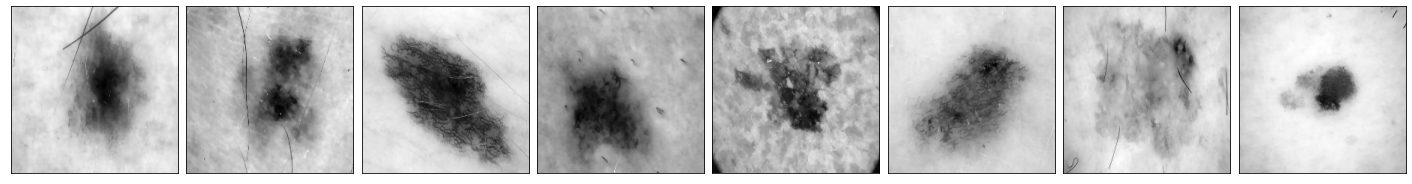

In [24]:
Display_images(new_imgs)

## Image Enhancement

In [48]:
def Image_enhancement(images_lst):
  enhanced = []
  # clipLimit: threshold for contrast limiting 
  # tileGridSize: Divides the input image into M x N tiles and then applies histogram equalization to each local tile
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))  # Instantiate the CLAHE algorithm
  for img in images_lst:
    enhanced_img = clahe.apply(img)  # apply histogram equalization
    enhanced.append(enhanced_img)
  return enhanced


In [45]:
Enhanced_images = Image_enhancement(new_imgs)

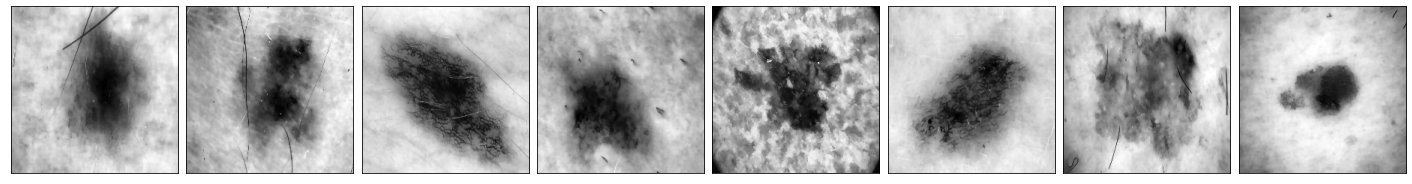

In [46]:
Display_images(Enhanced_images)

In [51]:
new_imgs

[array([[159, 160, 160, ..., 161, 161, 161],
        [160, 160, 160, ..., 161, 161, 161],
        [161, 161, 160, ..., 162, 163, 163],
        ...,
        [146, 147, 146, ..., 162, 162, 162],
        [146, 146, 145, ..., 162, 162, 161],
        [146, 145, 145, ..., 161, 160, 160]], dtype=uint8),
 array([[150, 150, 151, ..., 171, 170, 170],
        [150, 150, 150, ..., 170, 171, 170],
        [149, 149, 149, ..., 171, 171, 171],
        ...,
        [147, 148, 147, ..., 156, 159, 160],
        [147, 147, 147, ..., 155, 158, 158],
        [146, 147, 146, ..., 156, 158, 158]], dtype=uint8),
 array([[195, 195, 194, ..., 191, 191, 192],
        [195, 195, 194, ..., 190, 191, 191],
        [195, 196, 194, ..., 190, 190, 190],
        ...,
        [189, 196, 188, ..., 168, 167, 166],
        [189, 197, 188, ..., 168, 167, 166],
        [190, 200, 188, ..., 168, 167, 166]], dtype=uint8),
 array([[146, 146, 147, ..., 156, 155, 154],
        [145, 146, 148, ..., 156, 155, 155],
        [145, 14

In [55]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split( new_imgs, new_imgs, test_size = 0.30 )

In [56]:
x_train

[array([[23, 23, 22, ..., 37, 37, 37],
        [23, 23, 22, ..., 37, 37, 37],
        [23, 23, 21, ..., 38, 38, 38],
        ...,
        [38, 38, 37, ..., 21, 20, 20],
        [37, 37, 37, ..., 20, 19, 19],
        [37, 37, 37, ..., 20, 19, 19]], dtype=uint8),
 array([[139, 139, 139, ..., 148, 148, 148],
        [140, 139, 140, ..., 148, 148, 148],
        [141, 141, 141, ..., 149, 149, 148],
        ...,
        [142, 143, 142, ..., 145, 146, 146],
        [142, 142, 142, ..., 145, 146, 147],
        [142, 143, 142, ..., 145, 147, 147]], dtype=uint8),
 array([[133, 133, 132, ..., 109, 108, 107],
        [133, 133, 132, ..., 110, 108, 108],
        [134, 134, 133, ..., 111, 111, 110],
        ...,
        [ 81,  82,  84, ...,  82,  75,  72],
        [ 79,  80,  83, ...,  80,  71,  70],
        [ 79,  80,  82, ...,  76,  71,  69]], dtype=uint8),
 array([[136, 136, 139, ...,  81,  79,  79],
        [136, 136, 138, ...,  81,  80,  79],
        [137, 138, 139, ...,  82,  81,  81],
       

In [57]:
y_train

[array([[23, 23, 22, ..., 37, 37, 37],
        [23, 23, 22, ..., 37, 37, 37],
        [23, 23, 21, ..., 38, 38, 38],
        ...,
        [38, 38, 37, ..., 21, 20, 20],
        [37, 37, 37, ..., 20, 19, 19],
        [37, 37, 37, ..., 20, 19, 19]], dtype=uint8),
 array([[139, 139, 139, ..., 148, 148, 148],
        [140, 139, 140, ..., 148, 148, 148],
        [141, 141, 141, ..., 149, 149, 148],
        ...,
        [142, 143, 142, ..., 145, 146, 146],
        [142, 142, 142, ..., 145, 146, 147],
        [142, 143, 142, ..., 145, 147, 147]], dtype=uint8),
 array([[133, 133, 132, ..., 109, 108, 107],
        [133, 133, 132, ..., 110, 108, 108],
        [134, 134, 133, ..., 111, 111, 110],
        ...,
        [ 81,  82,  84, ...,  82,  75,  72],
        [ 79,  80,  83, ...,  80,  71,  70],
        [ 79,  80,  82, ...,  76,  71,  69]], dtype=uint8),
 array([[136, 136, 139, ...,  81,  79,  79],
        [136, 136, 138, ...,  81,  80,  79],
        [137, 138, 139, ...,  82,  81,  81],
       